In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import shapiro, f_oneway, friedmanchisquare, ttest_rel, wilcoxon, probplot
from statsmodels.stats.multitest import multipletests

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True


In [16]:
import os
import numpy as np
import os
print("CWD:", os.getcwd())

SCORES_DIR = "../results/cv_scores"  # notebook en src/results/

all_scores_p2 = {
    "SVM": np.load(os.path.join(SCORES_DIR, "probl2_svm_scores.npy")),
    "LogReg": np.load(os.path.join(SCORES_DIR, "probl2_logreg_scores.npy")),
    "KNN": np.load(os.path.join(SCORES_DIR, "probl2_knn_scores.npy")),
}

for k, v in all_scores_p2.items():
    print(k, v.shape, "mean=", v.mean(), "std=", v.std())


CWD: /home/olivia3/Machine-Learning-Project/src/results
SVM (30,) mean= 0.9464570331376715 std= 0.004193856981655107
LogReg (30,) mean= 0.9469407276812878 std= 0.0036490133094278683
KNN (30,) mean= 0.933011961577053 std= 0.0043908266615689095


In [8]:
SCORES_DIR = "../results/cv_scores"

paths = {
    "SVM": os.path.join(SCORES_DIR, "probl2_svm_scores.npy"),
    "LogReg": os.path.join(SCORES_DIR, "probl2_logreg_scores.npy"),
    "KNN": os.path.join(SCORES_DIR, "probl2_knn_scores.npy"),
}

all_scores_p2 = {}
for model, p in paths.items():
    all_scores_p2[model] = np.load(p)
    print(model, all_scores_p2[model].shape, "mean=", all_scores_p2[model].mean(), "std=", all_scores_p2[model].std())

SVM (30,) mean= 0.9464570331376715 std= 0.004193856981655107
LogReg (30,) mean= 0.9469407276812878 std= 0.0036490133094278683
KNN (30,) mean= 0.933011961577053 std= 0.0043908266615689095


In [17]:
for model, arr in all_scores_p2.items():
    if len(arr) != 30:
        print(f"⚠️ {model} tiene {len(arr)} scores (esperado 30: 10 folds x 3 repeats).")


In [18]:
summary_rows = []
for model, arr in all_scores_p2.items():
    summary_rows.append({
        "model": model,
        "n": len(arr),
        "mean": float(arr.mean()),
        "std": float(arr.std()),
        "min": float(arr.min()),
        "max": float(arr.max())
    })

summary_df_p2 = pd.DataFrame(summary_rows).sort_values("mean", ascending=False)
summary_df_p2


,model,n,mean,std,min,max
1,LogReg,30,0.946941,0.003649,0.938336,0.954925
0,SVM,30,0.946457,0.004194,0.938818,0.954940
2,KNN,30,0.933012,0.004391,0.924242,0.941155


In [11]:
alpha = 0.05

normality_rows = []
all_normal = True

for model, arr in all_scores_p2.items():
    stat, p = shapiro(arr)
    is_normal = p > alpha
    normality_rows.append({
        "model": model,
        "W": float(stat),
        "p_value": float(p),
        "normal(alpha=0.05)": bool(is_normal)
    })
    if not is_normal:
        all_normal = False

normality_df_p2 = pd.DataFrame(normality_rows).sort_values("p_value", ascending=True)
normality_df_p2, all_normal

(    model         W   p_value  normal(alpha=0.05)
 2     KNN  0.964539  0.402280                True
 0     SVM  0.968267  0.492909                True
 1  LogReg  0.980713  0.844183                True,
 True)

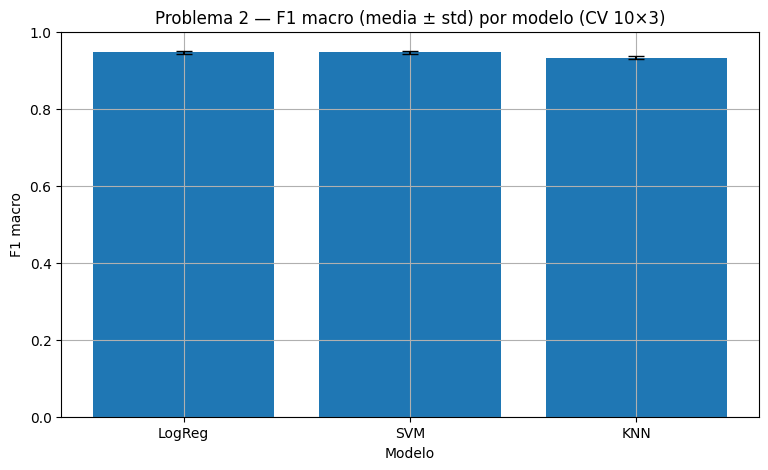

In [19]:
models = summary_df_p2["model"].tolist()
means = summary_df_p2["mean"].to_numpy()
stds  = summary_df_p2["std"].to_numpy()

plt.figure()
plt.bar(models, means, yerr=stds, capsize=6)
plt.ylim(0, 1.0)
plt.title("Problema 2 — F1 macro (media ± std) por modelo (CV 10×3)")
plt.ylabel("F1 macro")
plt.xlabel("Modelo")
plt.show()


/tmp/ipykernel_42979/1983824539.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=models, showmeans=True)


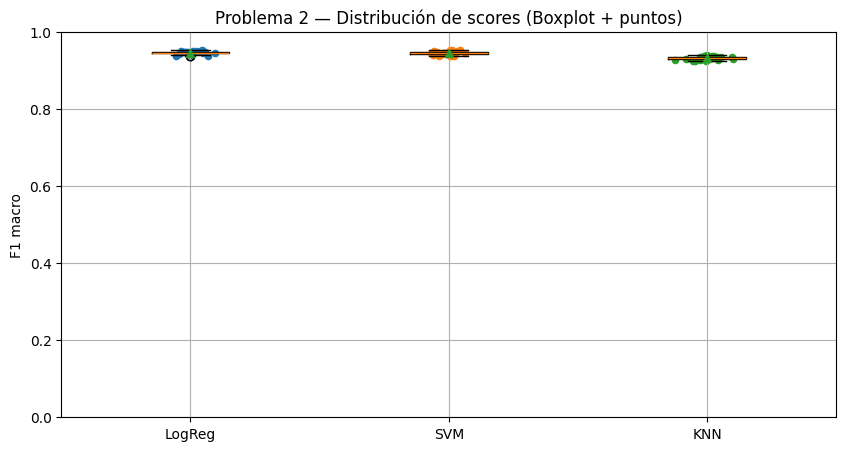

In [21]:
data = [all_scores_p2[m] for m in models]

plt.figure(figsize=(10, 5))
plt.boxplot(data, labels=models, showmeans=True)

# puntos jitter
for i, m in enumerate(models, start=1):
    y = all_scores_p2[m]
    x = np.random.normal(loc=i, scale=0.04, size=len(y))
    plt.scatter(x, y, s=20)

plt.ylim(0, 1.0)
plt.title("Problema 2 — Distribución de scores (Boxplot + puntos)")
plt.ylabel("F1 macro")
plt.show()


In [22]:
alpha = 0.05

best_model = summary_df_p2.iloc[0]["model"]
best_scores = all_scores_p2[best_model]

best_is_normal = bool(normality_df_p2[normality_df_p2["model"] == best_model]["normal(alpha=0.05)"].iloc[0])

pair_rows = []
pvals = []

for model, arr in all_scores_p2.items():
    if model == best_model:
        continue

    other_is_normal = bool(normality_df_p2[normality_df_p2["model"] == model]["normal(alpha=0.05)"].iloc[0])

    if best_is_normal and other_is_normal:
        test_name = "paired t-test"
        stat, p = ttest_rel(best_scores, arr)
    else:
        test_name = "Wilcoxon"
        try:
            stat, p = wilcoxon(best_scores, arr)
        except ValueError:
            stat, p = 0.0, 1.0

    pair_rows.append({
        "best": best_model,
        "vs": model,
        "test": test_name,
        "stat": float(stat),
        "p_value": float(p),
        "best_mean": float(best_scores.mean()),
        "vs_mean": float(arr.mean())
    })
    pvals.append(p)

reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method="holm")

for i, row in enumerate(pair_rows):
    row["p_value_holm"] = float(pvals_corr[i])
    row["significant(alpha=0.05)"] = bool(reject[i])

pairwise_df_p2 = pd.DataFrame(pair_rows).sort_values("p_value_holm", ascending=True)
pairwise_df_p2


,best,vs,test,stat,p_value,best_mean,vs_mean,p_value_holm,significant(alpha=0.05)
1,LogReg,KNN,paired t-test,21.836904,1.497685e-19,0.946941,0.933012,2.995370e-19,True
0,LogReg,SVM,paired t-test,0.905608,3.726063e-01,0.946941,0.946457,3.726063e-01,False


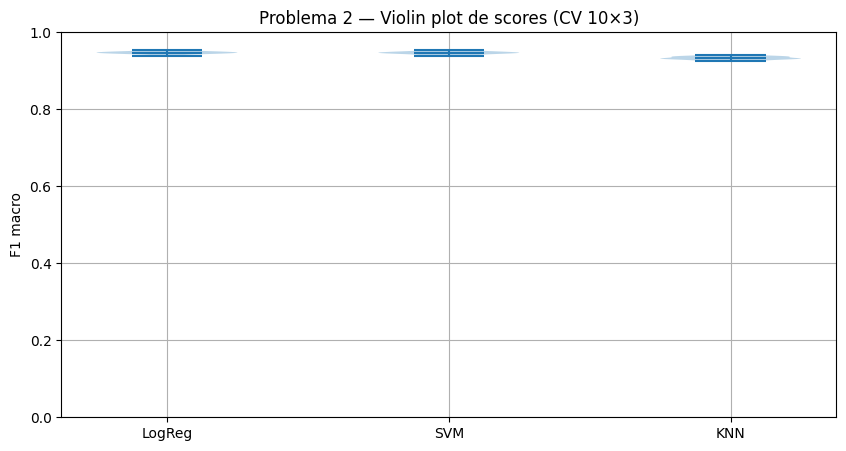

In [23]:
plt.figure(figsize=(10, 5))
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(ticks=range(1, len(models)+1), labels=models)
plt.ylim(0, 1.0)
plt.title("Problema 2 — Violin plot de scores (CV 10×3)")
plt.ylabel("F1 macro")
plt.show()


In [24]:
alpha = 0.05

normality_rows = []
all_normal = True

for model, arr in all_scores_p2.items():
    stat, p = shapiro(arr)
    is_normal = p > alpha
    normality_rows.append({
        "model": model,
        "W": float(stat),
        "p_value": float(p),
        "normal(alpha=0.05)": bool(is_normal)
    })
    if not is_normal:
        all_normal = False

normality_df_p2 = pd.DataFrame(normality_rows).sort_values("p_value", ascending=True)
normality_df_p2, all_normal


(    model         W   p_value  normal(alpha=0.05)
 2     KNN  0.964539  0.402280                True
 0     SVM  0.968267  0.492909                True
 1  LogReg  0.980713  0.844183                True,
 True)

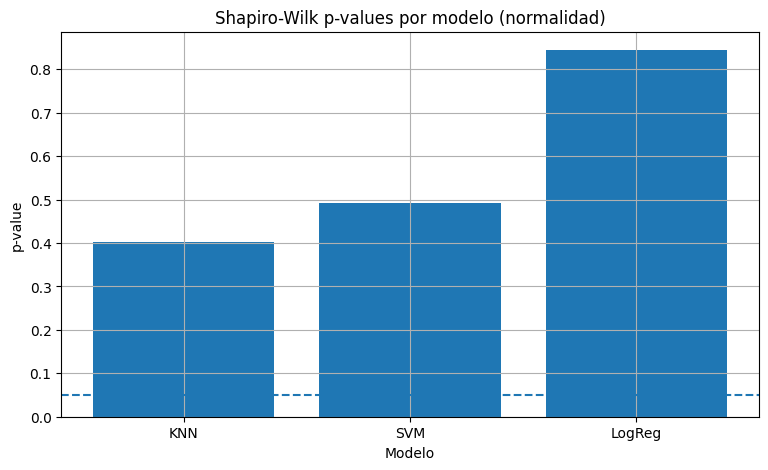

In [25]:
plt.figure()
plt.bar(normality_df_p2["model"], normality_df_p2["p_value"])
plt.axhline(0.05, linestyle="--")
plt.title("Shapiro-Wilk p-values por modelo (normalidad)")
plt.ylabel("p-value")
plt.xlabel("Modelo")
plt.show()


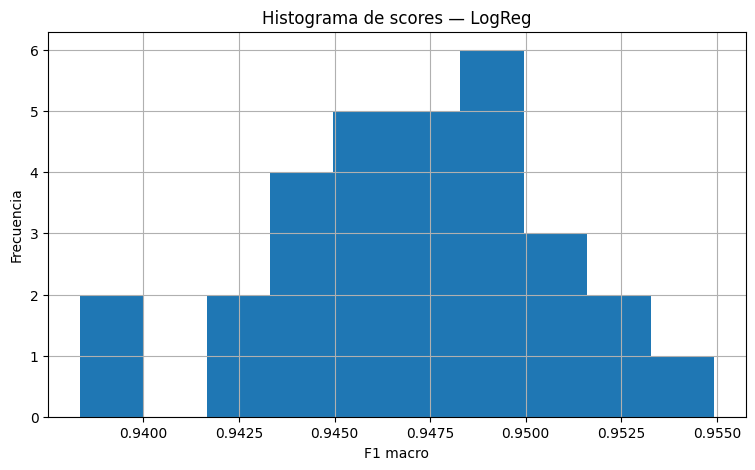

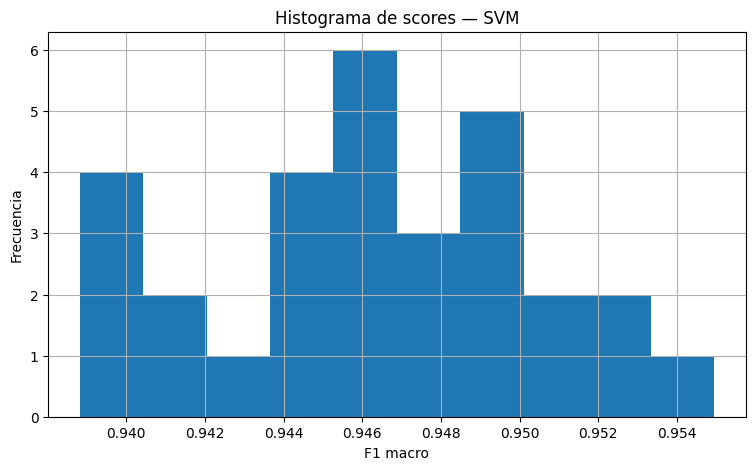

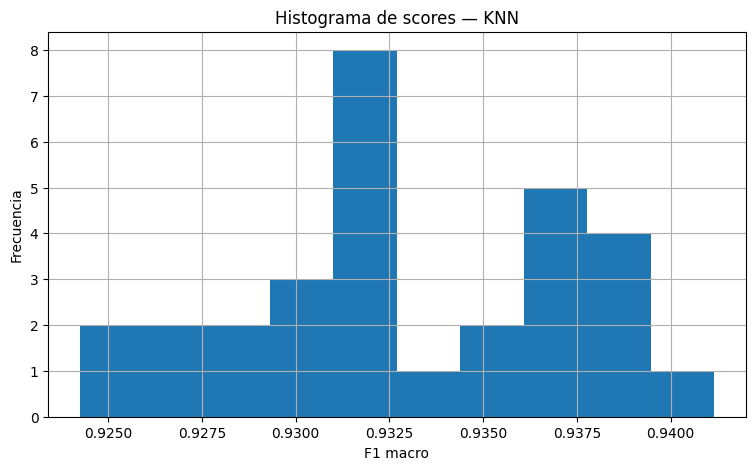

In [26]:
for m in models:
    plt.figure()
    plt.hist(all_scores_p2[m], bins=10)
    plt.title(f"Histograma de scores — {m}")
    plt.xlabel("F1 macro")
    plt.ylabel("Frecuencia")
    plt.show()


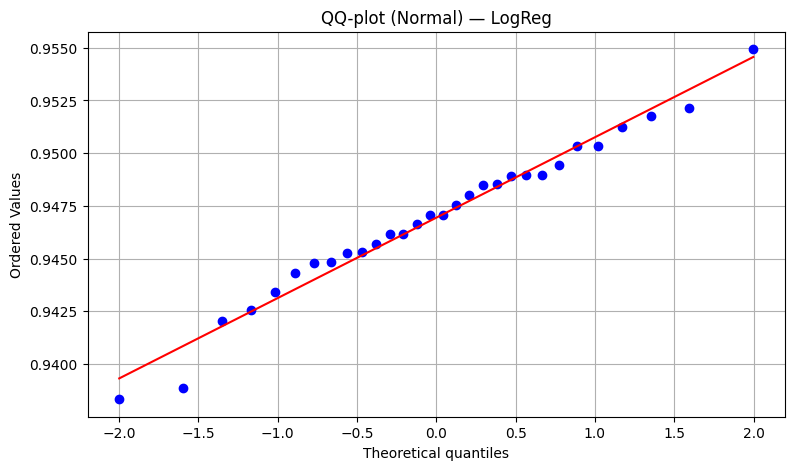

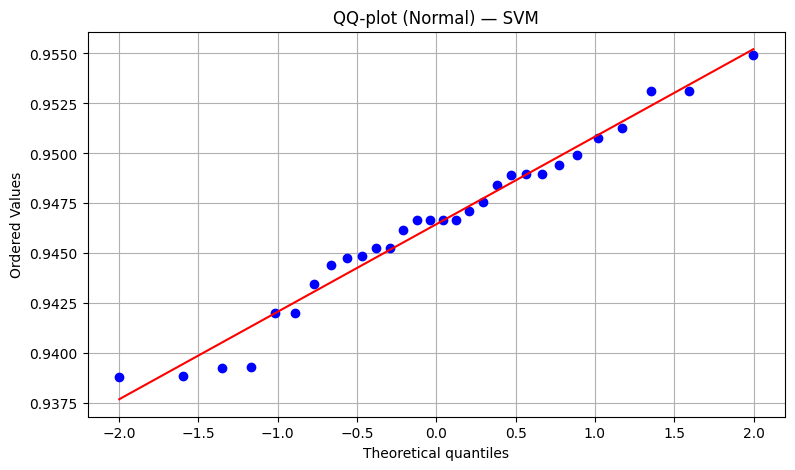

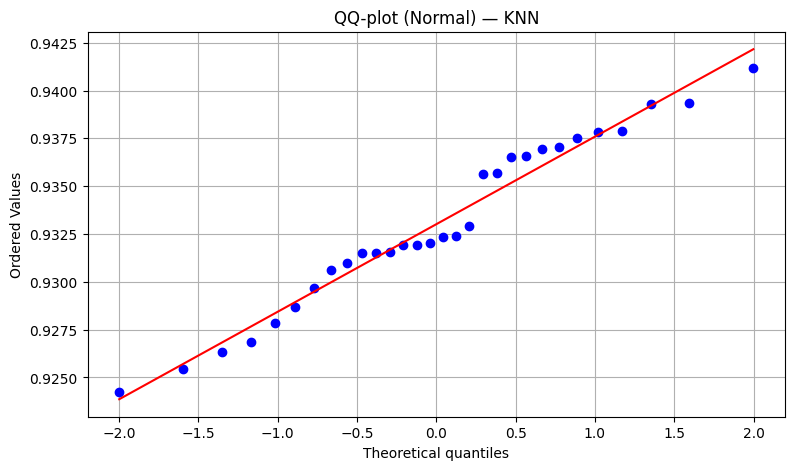

In [27]:
for m in models:
    plt.figure()
    probplot(all_scores_p2[m], dist="norm", plot=plt)
    plt.title(f"QQ-plot (Normal) — {m}")
    plt.show()


In [29]:
score_lists = [all_scores_p2[m] for m in models]

if all_normal:
    stat, p_global = f_oneway(*score_lists)
    global_test = "ANOVA"
else:
    stat, p_global = friedmanchisquare(*score_lists)
    global_test = "Friedman"

print("Global test:", global_test)
print("stat =", stat)
print("p_value =", p_global)


Global test: ANOVA
stat = 108.35739587633897
p_value = 2.4089009035241603e-24


In [32]:
print("==== CONCLUSIÓN (Problema 2) ====")
print("Ranking por media (F1_macro):")
display(summary_df_p2)

print("\nNormalidad (Shapiro):")
display(normality_df_p2)

print(f"\nTest global usado: {global_test} | p = {p_global:.6f}")

if p_global < 0.05:
    print("\n✅ Hay diferencias globales significativas.")
    print(f"Modelo con mayor media: {best_model}")
    print("Post-hoc (Holm) del mejor vs resto:")
    display(pairwise_df_p2)
else:
    print("\n⚠️ NO hay diferencias globales significativas.")
    print("Puedes elegir por media, por menor std, o por criterio práctico (simplicidad/tiempo).")


==== CONCLUSIÓN (Problema 2) ====
Ranking por media (F1_macro):


,model,n,mean,std,min,max
1,LogReg,30,0.946941,0.003649,0.938336,0.954925
0,SVM,30,0.946457,0.004194,0.938818,0.954940
2,KNN,30,0.933012,0.004391,0.924242,0.941155



Normalidad (Shapiro):


,model,W,p_value,normal(alpha=0.05)
2,KNN,0.964539,0.402280,True
0,SVM,0.968267,0.492909,True
1,LogReg,0.980713,0.844183,True



Test global usado: ANOVA | p = 0.000000

✅ Hay diferencias globales significativas.
Modelo con mayor media: LogReg
Post-hoc (Holm) del mejor vs resto:


,best,vs,test,stat,p_value,best_mean,vs_mean,p_value_holm,significant(alpha=0.05)
1,LogReg,KNN,paired t-test,21.836904,1.497685e-19,0.946941,0.933012,2.995370e-19,True
0,LogReg,SVM,paired t-test,0.905608,3.726063e-01,0.946941,0.946457,3.726063e-01,False
